# Sphere versus Torus

In this notebook, we attempt to use persistence landscapes to determine if TDA can tell the difference between a sphere and a torus. We sample 1000 points from each shape, compute the Vietoris-Rips persistent homology using Ripser, and then compute the respective landscapes in degree 1. 

To determine if we can see a difference, we will repeat this process 100 times and then compute the mean landscape across these 100 runs for the 2-sphere and for the torus. We take the difference between these two averages, which is again a persistence landscape, and take its supremum norm. This sup norm is treated as our threshold for significance.

We then put the 100 2-sphere landscapes and the 100 torus landscapes into a bag, and randomly draw out 100; call this group A. The group that remains in the bag is group B. We compute the average landscape of group A and the average landscape of group B. We compute the sup norm of the difference between these averages and compare it to our threshold. If it is greater than our threshold for significance, we deem this labelling significant. 

Our null hypothesis is that the initial labelling given by $S^2$ and the torus is significant. We reject the null hypothesis if the percentage of labellings that are significant is greater than 0.05%.

### Imports 

In [1]:
import numpy as np
import random

from ripser import ripser
from tadasets import sphere, torus
from PersistenceLandscapeGrid import PersistenceLandscapeGrid, snap_PL, average_grid
from visualization import plot_landscape_grid

### A single run

First, let's go step by step through the process. We sample 1000 points from the 2-sphere and from the torus. 

In [2]:
sphere_pts = sphere(n=1000)
torus_pts = torus(n=1000)

Compute the Vietoris-Rips persistent homology and the persistence landscapes in degree 1.

In [3]:
sphere_dgms = ripser(sphere_pts)['dgms']
torus_dgms = ripser(torus_pts)['dgms']

In [4]:
sph_pl = PersistenceLandscapeGrid(num_dims=500,
                                 dgms=sphere_dgms,
                                 hom_deg=1, compute=True)
tor_pl = PersistenceLandscapeGrid(num_dims=500,
                                 dgms=torus_dgms,
                                 hom_deg=1, compute=True)

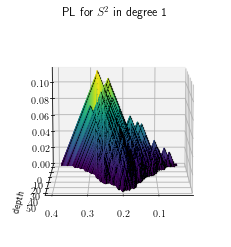

In [5]:
%matplotlib inline

plot_landscape_grid(sph_pl, title=r"PL for $S^2$ in degree 1")

In order to compare these two, we need to snap them onto the same grid. We use the `snap_PL` function provided to do so.

In [6]:
sph_pl, tor_pl = snap_PL([sph_pl, tor_pl])

In [7]:
diff_pl = sph_pl - tor_pl

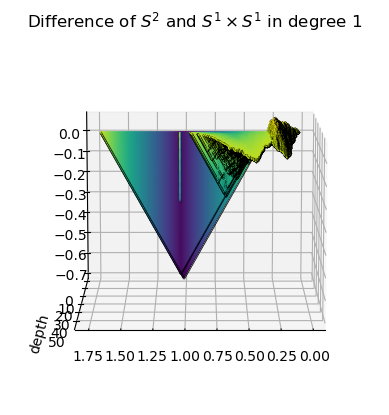

In [8]:
plot_landscape_grid(diff_pl, title=r"Difference of $S^2$ and $S^{1} \times S^{1}$ in degree 1")

The difference between the 2-sphere and torus is measured via the supremum norm of the difference between their persistence landscapes.

In [9]:
significant = diff_pl.sup_norm()

print(f'The threshold for significance is {significant}')

The threshold for significance is 0.7107387289016662


## 100 Runs

Now that we've done a single run, lets do it 100 times. 

In [10]:
sph_pl_list = []
tor_pl_list = []

for i in range(100):
    sph_pts = sphere(n=1000)
    sph_dgm = ripser(sph_pts)['dgms']
    sph_pl_list.append(PersistenceLandscapeGrid(dgms=sph_dgm,hom_deg=1,compute=True))
    
    tor_pts = torus(n=1000)
    tor_dgm = ripser(tor_pts)['dgms']
    tor_pl_list.append(PersistenceLandscapeGrid(dgms=tor_dgm,hom_deg=1,compute=True))

In [11]:
avg_sph = average_grid(sph_pl_list)
avg_tor = average_grid(tor_pl_list)

In [12]:
avg_sph, avg_tor = snap_PL([avg_sph, avg_tor])
diff_pl = avg_sph - avg_tor

Let's plot each of the averages and their differences.

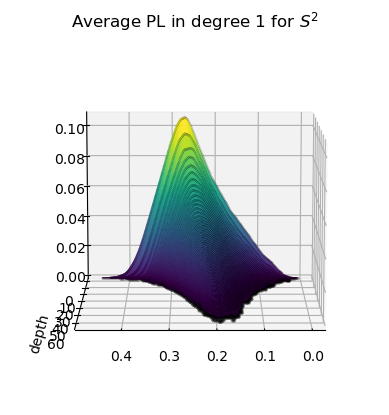

In [13]:
plot_landscape_grid(landscape=avg_sph, title=r"Average PL in degree 1 for $S^2$")

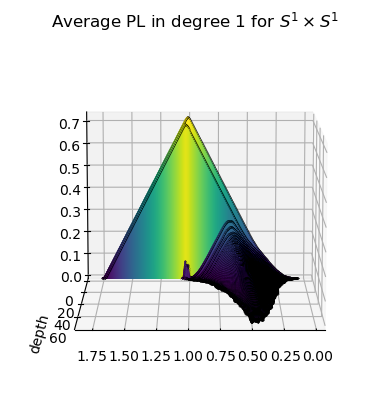

In [14]:
plot_landscape_grid(landscape=avg_tor, title=r"Average PL in degree 1 for $S^{1} \times S^{1}$")

The previous two plots really show how this is a toy experiment, since $S^2$ has no first-degree homology, whereas $S^1 \times S^1$ has two-dimensional first-degree homology. Even more, compare the width/support of the depth 1 landscape for $S^2$ (roughly 0.45) to the width/support of the depth 1 and 2 for $S^1 \times S^1$ (roughly 1.75).

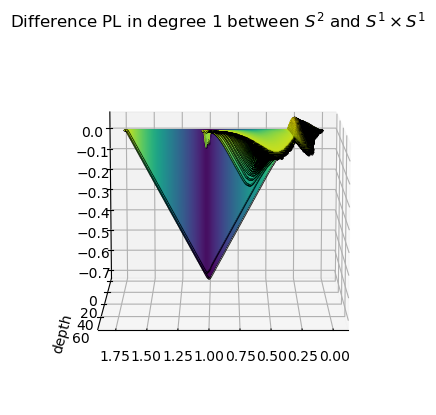

In [15]:
plot_landscape_grid(landscape=diff_pl, title=r"Difference PL in degree 1 between $S^2$ and $S^{1} \times S^{1}$")

Compute the supremum norm of the difference to establish a significant threshold.

In [16]:
significant = diff_pl.sup_norm()

So the significant threshold for our experiment is given by `significant`.

Now lets put all the landscapes into `full_list`. We snap them all on a common grid, and then grab out 100.

In [17]:
full_list = sph_pl_list + tor_pl_list
snapped_list = snap_PL(full_list)

In [18]:
num_sig = 0

for run in range(100):
    A_indices = random.sample(range(200), 100)
    B_indices = [_ for _ in range(200) if _ not in A_indices]
    
    A_pl_list = [snapped_list[i] for i in A_indices]
    B_pl_list = [snapped_list[j] for j in B_indices]
    
    A_sum = A_pl_list[0]
    B_sum = B_pl_list[0]
    for i in range(99):
        A_sum += A_pl_list[i+1]
        B_sum += B_pl_list[i+1]
    
    A_avg = A_sum/100.
    B_avg = B_sum/100.
    
    AB_diff = A_avg - B_avg
    if (AB_diff.sup_norm() > significant): num_sig += 1


print(f'Significant is {num_sig}') # Significant = 0

Significant is 0


**So there wasn't a single run which produced a more significant difference than the original labelling.**

What if we shuffle 500 times instead of 100?

In [19]:
num_sig = 0

for run in range(500):
    A_indices = random.sample(range(200), 100)
    B_indices = [_ for _ in range(200) if _ not in A_indices]
    
    A_pl_list = [snapped_list[i] for i in A_indices]
    B_pl_list = [snapped_list[j] for j in B_indices]
    
    A_sum = A_pl_list[0]
    B_sum = B_pl_list[0]
    for i in range(99):
        A_sum += A_pl_list[i+1]
        B_sum += B_pl_list[i+1]
    
    A_avg = A_sum/100.
    B_avg = B_sum/100.
    
    AB_diff = A_avg - B_avg
    if (AB_diff.sup_norm() > significant): num_sig += 1


print(f'Significant is {num_sig}') 

Significant is 0
